# Task 2-1 Streaming data visualisation

## 2-1-a

In [90]:
# import statements
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json

In [91]:
# home
# hostip = "192.168.1.101"

# library
hostip = "10.192.1.37"

<IPython.core.display.Javascript object>


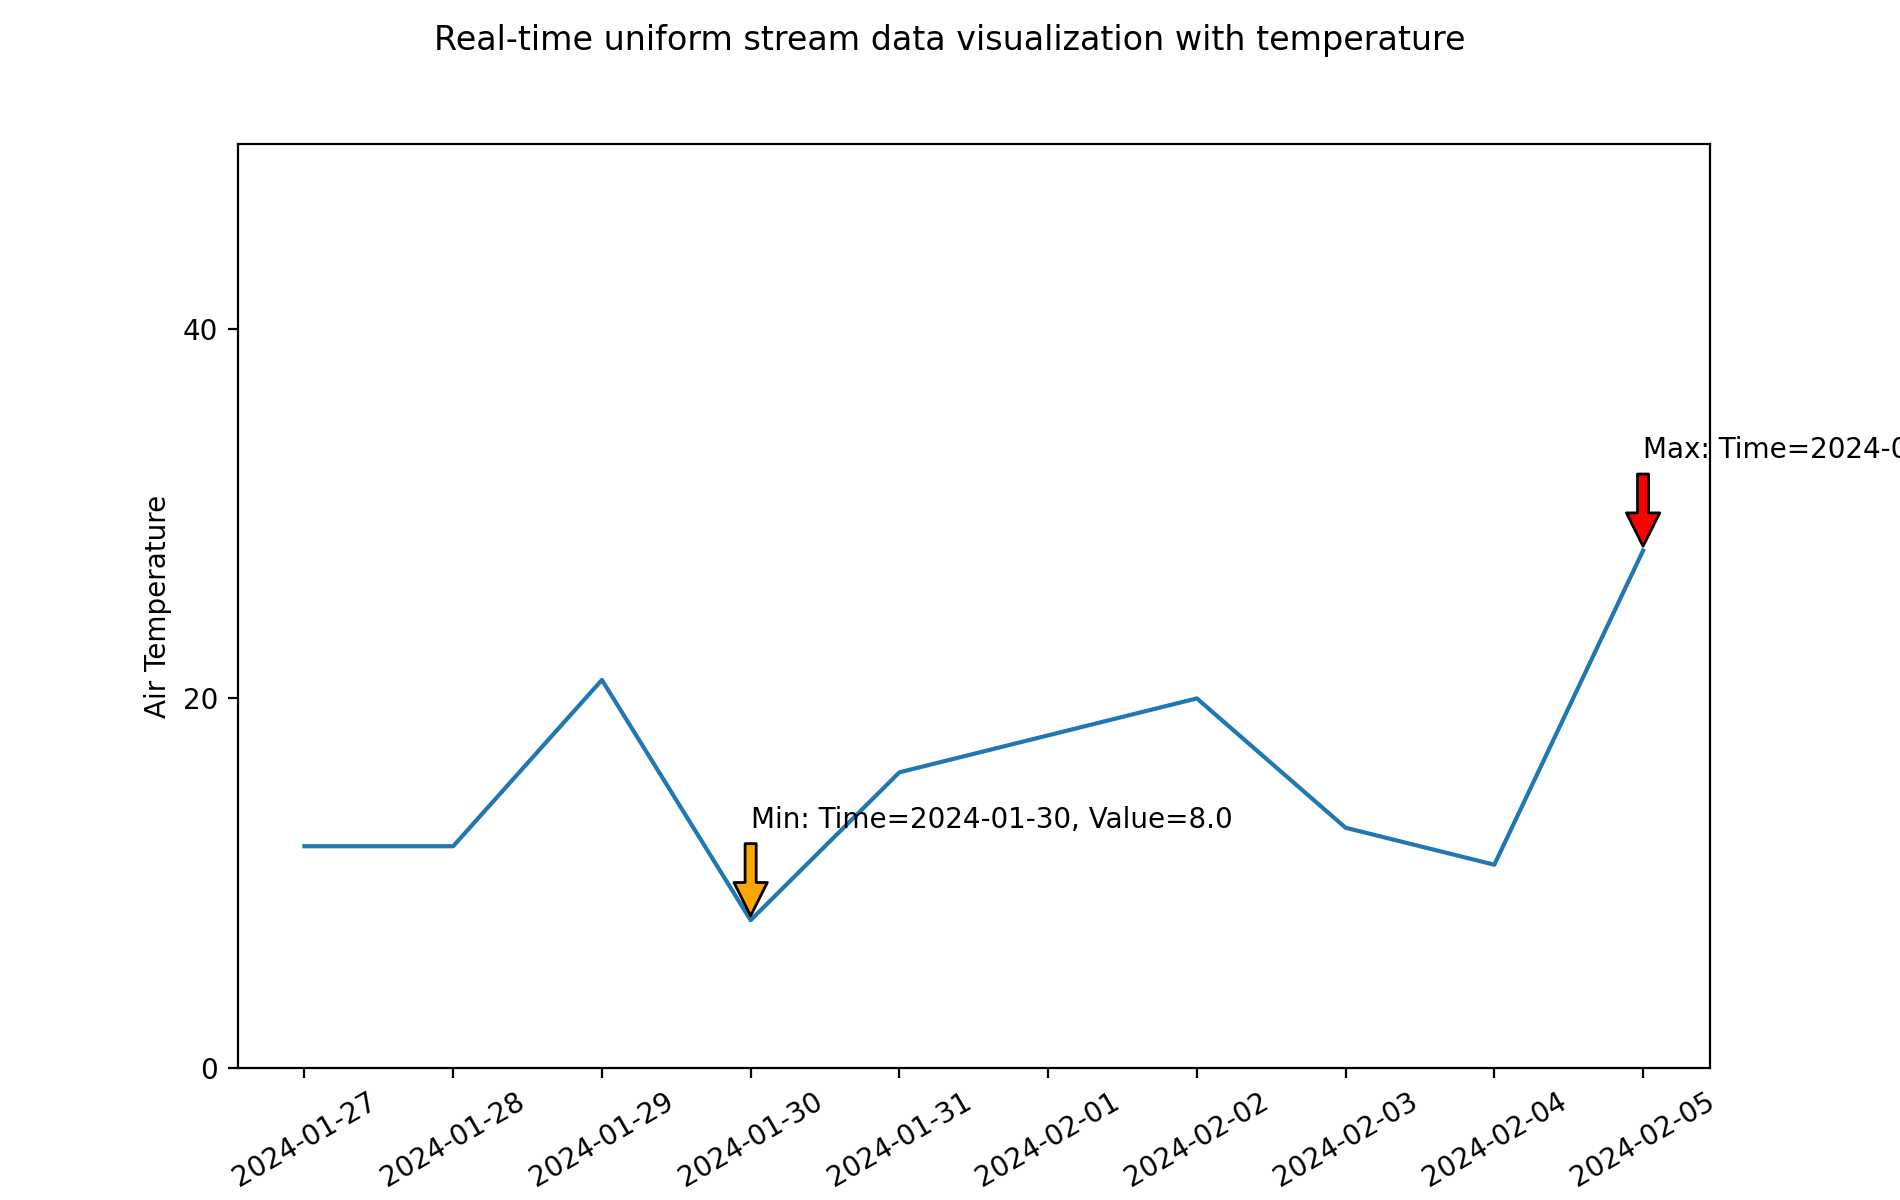

Waiting for messages


In [92]:
# display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'PartB1'

def annotate_max(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05))

def annotate_min(x, y, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05))

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=15000, # stop iteration if no message after 15 sec
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with temperature') # giving figure a title
        ax.set_xlabel('Air temperature')
        ax.set_ylabel('Arrival time')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        
        ax.tick_params(axis='x', rotation=30)  # Adjust the rotation angle as needed

        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8')).split(', ')

            key = message.key.decode("utf-8")
            
            if key == 'producer1':

                decode = str(message.value.decode('utf-8'))
                data = json.loads(decode)
                # print(data)
                x.append(data['created_time'][:10])

                y.append(float(data['air_temperature_celcius']))
                
#                 print(data['air_temperature_celcius'])

                # we start plotting only when we have 10 data points
                
                if len(y) > 9:
                    
                    ax.clear()
                    ax.plot(x, y)
                    ax.set_xlabel('Arrival Time')
                    ax.set_ylabel('Air Temperature')
                    ax.set_ylim(0,50) 
                    ax.set_yticks([0,20,40])
                    annotate_max(x,y)
                    annotate_min(x,y)
                    fig.canvas.draw()
                    
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
                    
                 
                    
#         plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

during 2024-01-27 ~ 2024-02-05, the lowest air temperature is 8'C, on 2024-01-30. the highest air temperature is 28'C on 2024-02-04

# Task 2-2 Static data visualisation

## 2-2-a

In [101]:
import sys, getopt, pprint
from pymongo import MongoClient
from pprint import pprint
from datetime import datetime as datetime

# home
# client = MongoClient('mongodb://192.168.1.101:27017/')

# library
client = MongoClient('mongodb://10.192.1.37:27017/')

# make database
db = client.fit3182_assignment1_db

# add new collection into new database
collection = db.hotspot

In [108]:
from pymongo import MongoClient
from collections import defaultdict

# set the dictionary, it will be based on the time 0 ~ 23
Daytohour = defaultdict(int)



# collect all the data
for document in collection.find():
    
    # get hotspot information
    hotspot_data = document.get('hotspot', [])
    
    # find the hour
    for hotspot in hotspot_data:
        datetime_obj = hotspot.get('created_time')
        datetime_obj = datetime.strptime(datetime_obj, "%Y-%m-%d %H:%M:%S")
    
        if datetime_obj:
            hour = datetime_obj.hour

            Daytohour[hour] += 1

# result for the number of "hour"
for hour in range(24):
    count = Daytohour[hour]
    print(f"Hour: {hour}, Count: {count}")

Hour: 0, Count: 1
Hour: 1, Count: 0
Hour: 2, Count: 0
Hour: 3, Count: 0
Hour: 4, Count: 0
Hour: 5, Count: 0
Hour: 6, Count: 0
Hour: 7, Count: 0
Hour: 8, Count: 0
Hour: 9, Count: 0
Hour: 10, Count: 0
Hour: 11, Count: 0
Hour: 12, Count: 0
Hour: 13, Count: 0
Hour: 14, Count: 0
Hour: 15, Count: 0
Hour: 16, Count: 0
Hour: 17, Count: 2
Hour: 18, Count: 0
Hour: 19, Count: 0
Hour: 20, Count: 0
Hour: 21, Count: 0
Hour: 22, Count: 1
Hour: 23, Count: 0


<IPython.core.display.Javascript object>


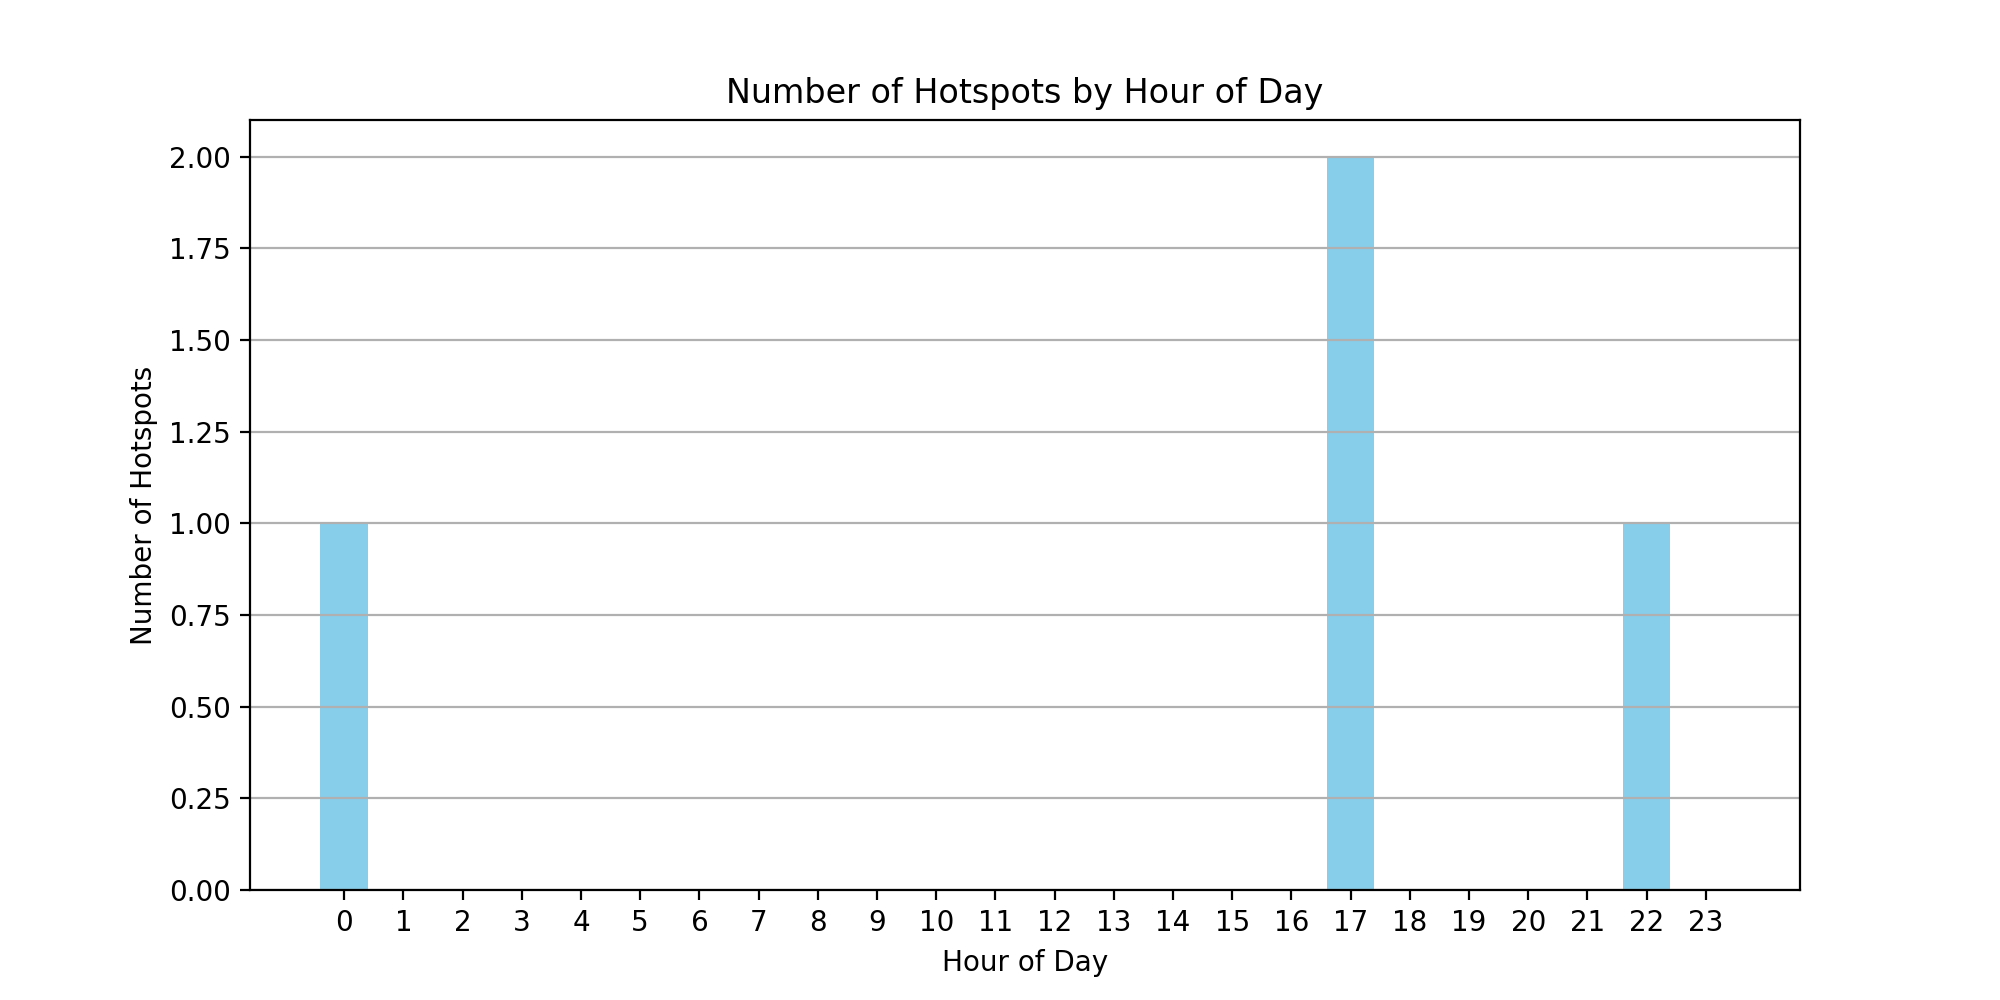

In [109]:
# prepare for making barplot from our dict dataset

hours = list(Daytohour.keys())
counts = list(Daytohour.values())

# barplot
plt.figure(figsize=(10, 5))
plt.bar(hours, counts, color='skyblue')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Hotspots')
plt.title('Number of Hotspots by Hour of Day')
plt.xticks(range(24))  # 24 hour format time.
plt.grid(axis='y')

# show
plt.show()

## 2-2-b

In [110]:
import folium
from pprint import pprint

#Melbourne city
m = folium.Map(location = [-37.8136, 144.9631], zoom_start=6) 

In [111]:
fire_lst = []

for document in collection.find():
    
    if len(document['hotspot']) != 0:

        h_air_temp = document['air_temperature_celcius']
        h_humidity = document['relative_humidity']
        info = document['hotspot']

        for i in info:
            h_latitude = i['latitude']
            h_longitude = i['longitude']
            h_surface_temp = i['surface_temperature_celcius']
            h_confidence = i['confidence']
            h_event = i['event']

            fire_lst.append([h_latitude, h_longitude, h_air_temp, h_surface_temp, h_humidity, h_confidence, h_event])
# pprint(fire_lst)

In [112]:
import pandas as pd

final_data = []

# add the attribute into the data frame
for record in fire_lst:
    final_data.append({
        'h_latitude': record[0],
        'h_longitude': record[1],
        'h_air_temp': record[2],
        'h_surface_temp': record[3],
        'h_humidity': record[4],
        'h_confidence': record[5],
        'h_event': record[6]
    })
    
# make dataframe
final_DataFrame = pd.DataFrame(final_data)

# print dataframe
final_DataFrame

,h_latitude,h_longitude,h_air_temp,h_surface_temp,h_humidity,h_confidence,h_event
0,-36.3539,142.1894,22.0,53.0,46.9,53.0,natural
1,-36.6029,144.6259,14.0,115.0,52.5,100.0,other
2,-37.3680,148.0500,8.0,53.0,42.6,79.0,other
3,-36.8158,142.8794,17.0,43.0,52.5,66.0,other


In [113]:
for i in range(0, len(final_DataFrame)):
    folium.Marker(
        location=[final_DataFrame.iloc[i]['h_latitude'], final_DataFrame.iloc[i]['h_longitude']],
        popup=folium.Popup(
            "Air temperature: {}°C\n".format(final_DataFrame.iloc[i]['h_air_temp']) +
            "Surface Temperature: {}°C\n".format(final_DataFrame.iloc[i]['h_surface_temp']) +
            "Relative Humidity: {}%\n".format(final_DataFrame.iloc[i]['h_humidity']) +
            "Confidence: {}%\n".format(final_DataFrame.iloc[i]['h_confidence'])
        ), 
        icon=folium.Icon(color='red') if final_DataFrame.iloc[i]['h_event'] == 'other' else folium.Icon(color='blue')
    ).add_to(m)

# Show the map again
m


I could see that there is 1 natural, and 3 others data.